## Imports

# Отчет смотрите пожалуйста, в конце ноутбука 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
%matplotlib inline
import torch

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## Data Prep

In [ ]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col=None)

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
data[categorical_columns] = data[categorical_columns].fillna('NaN')  # cast missing values to string "NaN"

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = data["FullDescription"].apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
data["Title"] = data["Title"].apply(lambda x: " ".join(tokenizer.tokenize(str(x).lower())))

--2022-10-03 14:13:36--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.170.2
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.170.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  13.8MB/s    in 10s     

2022-10-03 14:13:47 (11.8 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


In [ ]:
token_counts = Counter()
for row in data["Title"]:
    token_counts.update(row.split())
for row in data["FullDescription"]:
    token_counts.update(row.split())

min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {token: idx for idx, token in enumerate(tokens)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))
n_cat_features = len(categorical_vectorizer.vocabulary_)

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


## Ala utils

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])


def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = 3 if max_len < 3 else max_len

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix


import torch


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=DEVICE):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX, ):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])



def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=DEVICE):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start: start + batch_size]])
            yield batch

        if not cycle: break


# Architectures

In [ ]:
from torch import nn
import torch
import gensim.downloader as api

## Embeddings layer

In [ ]:
glove = api.load('glove-wiki-gigaword-100')
class TextEmbeddings(nn.Module):
    def __init__(self, vocab, method="finetune", embedding_dim=100, glove=glove):
        super().__init__()
        self.token_to_id = vocab

        if method == "finetune" or method == "freeze":
            if glove is None:
                self.glove = api.load('glove-wiki-gigaword-100')
            else:
                self.glove = glove
            self.embeddings_matrix = self.build_emb_matrix()
            self.embeddings = nn.Embedding.from_pretrained(self.embeddings_matrix,
                                                           freeze=(method == "freeze")).to(DEVICE)
        else:
            self.embeddings = nn.Embedding(len(vocab), embedding_dim)

    def __call__(self, batch):
        return self.embeddings(batch)

    def build_emb_matrix(self):
        embeddings_matrix = np.zeros((len(self.token_to_id), 100))
        for word, index in self.token_to_id.items():
            if word in self.glove:
                embeddings_matrix[index] = self.glove.get_vector(word)
            else:
                embeddings_matrix[index] = np.random.uniform(-0.5, 0.5, 100)
        return torch.tensor(embeddings_matrix, device=DEVICE, dtype=torch.float32)

[==================================================] 100.0% 128.1/128.1MB downloaded


## Convolution layers

In [ ]:
class OneConv(nn.Module):
    def __init__(self, in_channels, out_channels, k):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=k, padding='same'),
            nn.ReLU()
        ).to(DEVICE)

    def forward(self, embeddings):
        x = torch.permute(embeddings, (0, 2, 1))
        conv_x = self.layer(x)
        return torch.permute(conv_x, (0, 2, 1))


class ParallelConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernels):
        super().__init__()
        self.kernels = kernels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.layers = [OneConv(in_channels, out_channels, k) for k in kernels]

    def forward(self, x):
        embeddings, batch_idx = x
        return torch.cat([layer(embeddings) for layer in self.layers], dim=-1), batch_idx

## Pooling Layers

In [ ]:
class MAxOverTime(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, x):
        x, _ = x
        out, _ = x.max(1)
        return out


class AverageOverTime(nn.Module):
    def __init__(self):
        super(AverageOverTime, self).__init__()

    def __call__(self, x):
        x, batch_idx = x
        batch_size, seq_length = batch_idx.shape
        mask = (batch_idx != 1).to(torch.float32)
        out = (mask.view(batch_size, seq_length, 1)) * x
        return out.sum(1) / mask.sum(1, keepdims=True)


class SoftMaxPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, x):
        x, batch_idx = x
        out = nn.Softmax(dim=1)(x)
        return (out * x).sum(1)


class AttentivePooling(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, x):
        x, batch_idx = x
        _, _, out_channels = x.shape
        self.linear = nn.Linear(out_channels, out_channels).to(DEVICE)
        dense = self.linear(x)
        self.softmax = nn.Softmax(1).to(DEVICE)
        attn = self.softmax(dense)
        out = (x * attn).sum(1)
        return out

## LSTM LAYERS

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, method=1):
        super().__init__()
        self.method = method
        self.lstm = nn.LSTM(input_size=in_channels, hidden_size=out_channels,
                            batch_first=True, bidirectional=True)

    def __call__(self, x):
        embedding, batch_ids = x
        output, (hn, cn) = self.lstm(embedding)
        if self.method == 1:
            return torch.cat([hn[0], hn[1]], dim=1)
        else:
            return output, batch_ids

# Models

## A) CNN architecture


In [ ]:
class SalaryPredictorCNN(nn.Module):
    def __init__(self, vocab, in_channels, out_channels, kernels, pooling='max_pool', emb_method="finetune"):
        super().__init__()

        self.pooling_options = {
            'max_pool': MAxOverTime,
            'average_pool': AverageOverTime,
            'soft_pool': SoftMaxPooling,
            'attn_pool': AttentivePooling,
        }

        self.embedding_layer = TextEmbeddings(vocab, embedding_dim=in_channels, method = emb_method)
        self.title_encoder = nn.Sequential(
            ParallelConv(in_channels, out_channels, kernels),
            self.pooling_options[pooling]()
        )
        self.description_encoder = nn.Sequential(
            ParallelConv(in_channels, out_channels, kernels),
            self.pooling_options[pooling]()
        )
        self.categorical_encoder = nn.Linear(n_cat_features, out_channels * 3)
        self.bn = nn.BatchNorm1d(9 * out_channels)
        self.linear = nn.Linear(9 * out_channels, 1)

    def forward(self, batch):
        title_embeddings = self.embedding_layer(batch["Title"])
        description_embeddings = self.embedding_layer(batch["FullDescription"])

        title_out = self.title_encoder((title_embeddings, batch['Title']))
        description_out = self.description_encoder((description_embeddings, batch['FullDescription']))
        categorical_out = self.categorical_encoder(batch['Categorical'])
        encode_sentence = torch.cat([title_out, description_out, categorical_out], dim=1)
        out = self.bn(encode_sentence)
        out = self.linear(out)
        out = torch.squeeze(out, 1)
        return out

    @property
    def device(self):
        return next(self.parameters()).device

## C) LSTM architecture

In [ ]:
class SalaryPredictorLSTM(nn.Module):
    def __init__(self, vocab, in_channels, out_channels, pooling='max_pool', method=2):
        super().__init__()

        self.method = method
        self.pooling_options = {
            'max_pool': MAxOverTime,
            'average_pool': AverageOverTime,
            'soft_pool': SoftMaxPooling,
            'attn_pool': AttentivePooling,
        }
        self.drop_out = nn.Dropout(p=0.01) 

        self.embedding_layer = TextEmbeddings(vocab, method=" ", embedding_dim=in_channels)
        if self.method == 1:
            self.title_encoder = EncoderLSTM(in_channels, out_channels, method=1)
            self.description_encoder = EncoderLSTM(in_channels, out_channels, method=1)
            self.bn = nn.BatchNorm1d(7 * out_channels)
            
            self.linear = nn.Linear(7 * out_channels, 1)

        else:
            self.title_encoder = nn.Sequential(
                EncoderLSTM(in_channels, out_channels, method=2),
                self.pooling_options[pooling]()
            )
            self.description_encoder = nn.Sequential(
                EncoderLSTM(in_channels, out_channels, method=2),
                self.pooling_options[pooling]()
            )

            self.bn = nn.BatchNorm1d(7 * out_channels)
            self.linear = nn.Linear(7 * out_channels, 1)

        self.categorical_encoder = nn.Linear(n_cat_features, out_channels * 3)

    def __call__(self, batch):
        title_embeddings = self.embedding_layer(batch["Title"])
        description_embeddings = self.embedding_layer(batch["FullDescription"])

        title_out = self.title_encoder((title_embeddings, batch['Title']))
        description_out = self.description_encoder((description_embeddings, batch['FullDescription']))
        categorical_out = self.categorical_encoder(batch['Categorical'])
        encode_sentence = torch.cat([title_out, description_out, categorical_out], dim=1)

        out = self.bn(encode_sentence)
        out = self.drop_out(out)
        out = self.linear(out)
        out = torch.squeeze(out, 1)
        return out

## D) LSTM + Conv

In [ ]:
class SalaryPredictorCNN_LSTM(nn.Module):
    def __init__(self, vocab, in_channels, out_channels, kernels, pooling='max_pool'):
        super().__init__()

        self.pooling_options = pooling_options = {
            'max_pool': MAxOverTime,
            'average_pool': AverageOverTime,
            'soft_pool': SoftMaxPooling,
            'attn_pool': AttentivePooling,
        }

        self.embedding_layer = TextEmbeddings(vocab, method=" ", embedding_dim=in_channels)
        self.title_encoder = nn.Sequential(
            ParallelConv(in_channels, out_channels, kernels),
            self.pooling_options[pooling]()
        )
        self.description_encoder = nn.Sequential(
            EncoderLSTM(in_channels, out_channels, method=2),
            self.pooling_options[pooling]()
        )
        self.categorical_encoder = nn.Linear(n_cat_features, out_channels * 3)
        self.bn = nn.BatchNorm1d(8 * out_channels)
        self.linear = nn.Linear(8 * out_channels, 1)

    def __call__(self, batch):
        title_embeddings = self.embedding_layer(batch["Title"])
        description_embeddings = self.embedding_layer(batch["FullDescription"])

        title_out = self.title_encoder((title_embeddings, batch['Title']))
        description_out = self.description_encoder((description_embeddings, batch['FullDescription']))
        categorical_out = self.categorical_encoder(batch['Categorical'])
        encode_sentence = torch.cat([title_out, description_out, categorical_out], dim=1)

        out = self.bn(encode_sentence)
        out = self.linear(out)
        out = torch.squeeze(out, 1)
        return out

# Experiments

In [ ]:
from IPython.display import clear_output

def train(epoch, data_train, model, loss_fn, optimizer, sched=None, grad_clip=0.1, show=False):
    model.train()
    num_batches = len(data_train) // BATCH_SIZE
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
                total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        if sched is not None:
            sched.step()
        # Progress output
        if i % interval == 0:
            t = epoch + (i + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            if show:
                show_progress(t)



def test(epoch, data, model, criterion, batch_size=16):
    model.eval()
    num_batches = len(data_val) // BATCH_SIZE
    size = len(data_val)
    
    num_samples, test_loss, abs_error = 0, 0, 0
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False):
            batch_pred = model(batch)
            test_loss += criterion(batch_pred, batch[TARGET_COLUMN]).item()
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)

    test_loss /= num_batches
    mse = abs_error.detach().cpu().numpy() / num_samples

    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(mse)
    lr.append(get_lr(optimizer))
    show_progress(epoch+1)




def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts[1:], train_loss[1:], c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('MSE')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


### 1. RNN Text Encoder with average pooling.
Two experiments: with learnable embeddings and finetuned. 




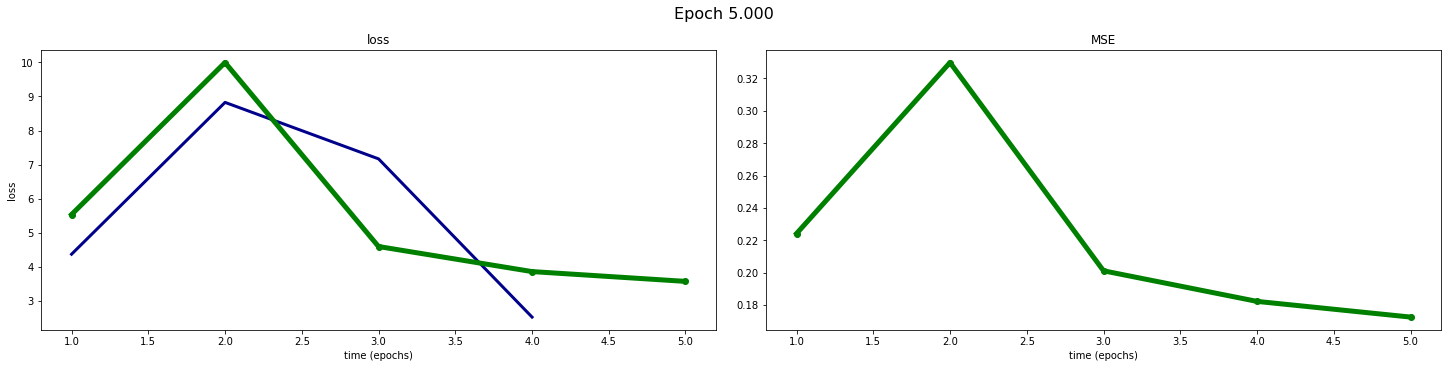

In [ ]:
interval = 5_000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='average_pool', emb_method="learn").to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
num_batches = len(data_train) // BATCH_SIZE
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)


In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 6641.1606 Val Loss 5.5341 MSE 0.22411008213705724
Epoch 2 LR 0.0095 Train Loss 4.3715 Val Loss 9.9948 MSE 0.3298305232973812
Epoch 3 LR 0.0061 Train Loss 8.8255 Val Loss 4.5968 MSE 0.2011074411054255
Epoch 4 LR 0.0019 Train Loss 7.1683 Val Loss 3.8615 MSE 0.18220520954620664
Epoch 5 LR 0.0000 Train Loss 2.5268 Val Loss 3.5738 MSE 0.17251257637910078


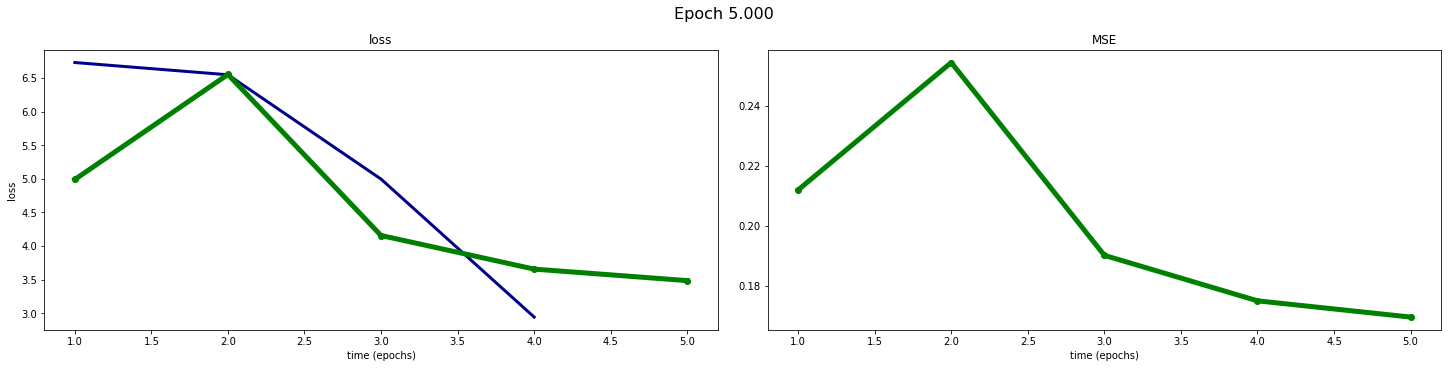

In [ ]:
interval = 5_000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='average_pool', emb_method="finetune").to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

from IPython.display import clear_output
for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 6912.1201 Val Loss 4.9903 MSE 0.21200347200943742
Epoch 2 LR 0.0095 Train Loss 6.7292 Val Loss 6.5521 MSE 0.25442573082000447
Epoch 3 LR 0.0061 Train Loss 6.5473 Val Loss 4.1574 MSE 0.1902263915806165
Epoch 4 LR 0.0019 Train Loss 4.9956 Val Loss 3.6577 MSE 0.17508105504657434
Epoch 5 LR 0.0000 Train Loss 2.9446 Val Loss 3.4867 MSE 0.16967225849138987


### 2. CNN + Attentive Pooling and SoftMAx
       'soft_pool': SoftMaxPooling,
            'attn_pool': AttentivePooling,

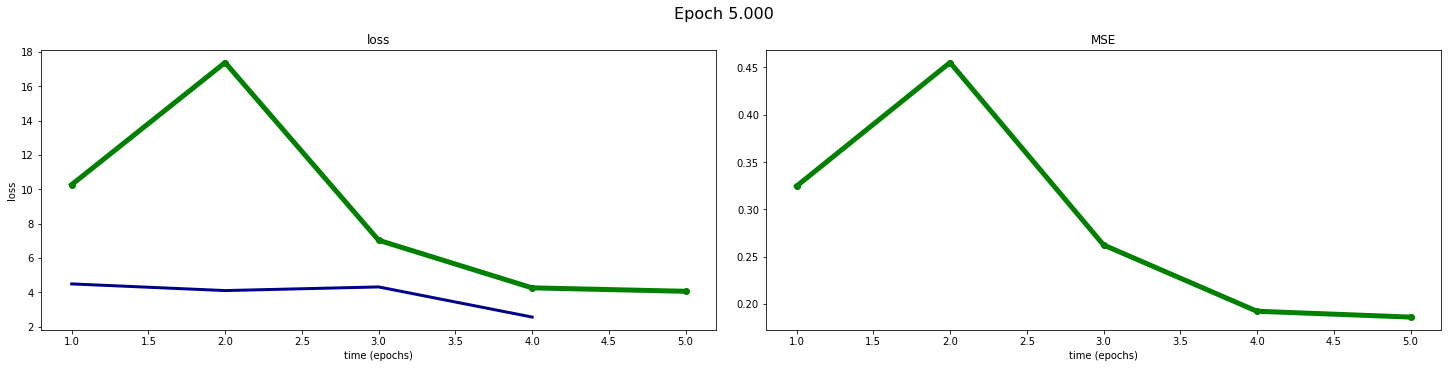

In [ ]:
interval = 5_000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='soft_pool', emb_method="finetune").to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

from IPython.display import clear_output
for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 6901.7881 Val Loss 10.2647 MSE 0.3246370117546574
Epoch 2 LR 0.0095 Train Loss 4.4888 Val Loss 17.3776 MSE 0.4552153711903011
Epoch 3 LR 0.0061 Train Loss 4.1005 Val Loss 7.0315 MSE 0.2624316322465988
Epoch 4 LR 0.0019 Train Loss 4.3131 Val Loss 4.2594 MSE 0.1923848472545655
Epoch 5 LR 0.0000 Train Loss 2.5579 Val Loss 4.0584 MSE 0.18626175210401602


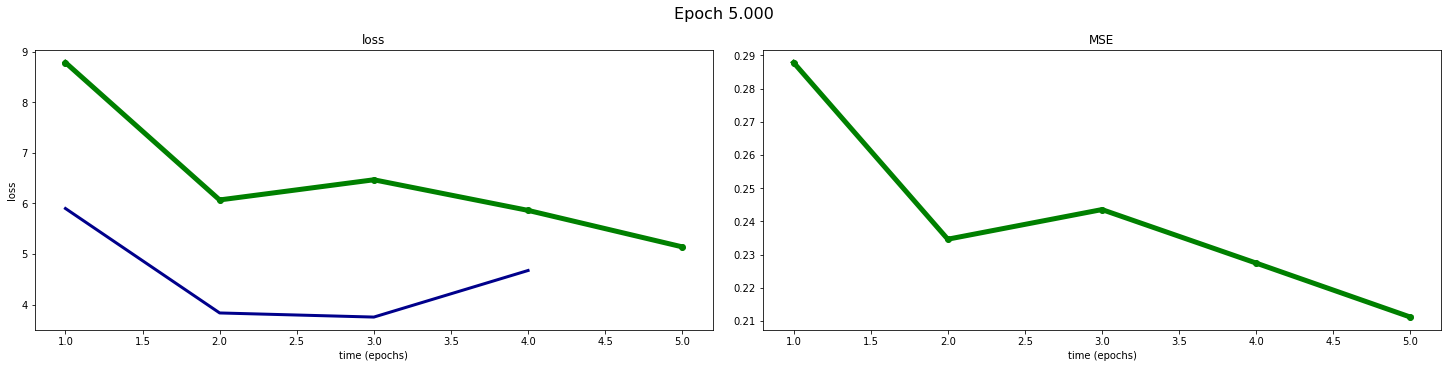

In [ ]:
interval = 5_000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='attn_pool', emb_method="finetune").to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

from IPython.display import clear_output
for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 6691.7090 Val Loss 8.7825 MSE 0.2878433628380725
Epoch 2 LR 0.0095 Train Loss 5.8980 Val Loss 6.0671 MSE 0.23464887397480289
Epoch 3 LR 0.0061 Train Loss 3.8336 Val Loss 6.4653 MSE 0.24356851984133063
Epoch 4 LR 0.0019 Train Loss 3.7523 Val Loss 5.8607 MSE 0.22745791170026963
Epoch 5 LR 0.0000 Train Loss 4.6728 Val Loss 5.1398 MSE 0.21120363392802427


Видно, что с такими пулингами мы переобучаемся, можно попробовать накинуть регуляризацию посильнее 

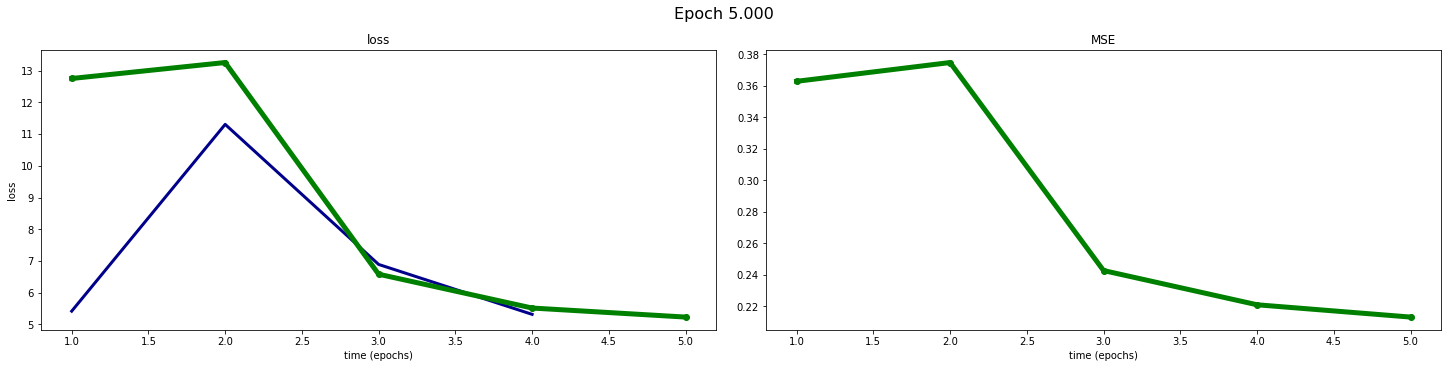

In [ ]:
interval = 5_000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='attn_pool', emb_method="finetune").to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-2
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

from IPython.display import clear_output
for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

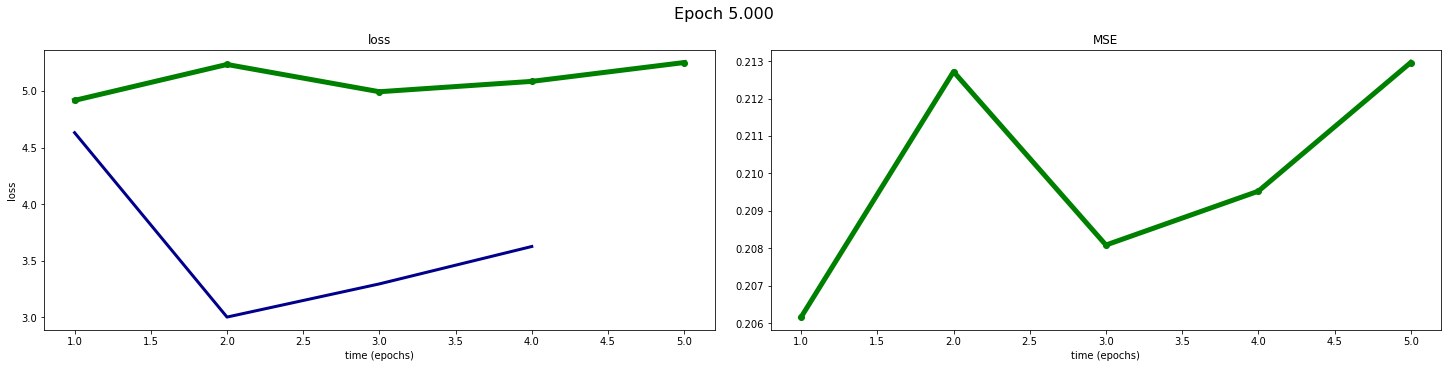

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
# model = SalaryPredictorCNN(token_to_id, 100, 5, kernels=(2, 3, 4), pooling='attn_pool', emb_method="finetune").to(DEVICE)
epochs = 5
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-2
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 

from IPython.display import clear_output
for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=None)
    test(t, data_val, model, criterion)

## 3. LSTM 
Two models: one with all hidden states concatination and average pooling, and second model - uses one hidden state per direction to represent the sentence. 

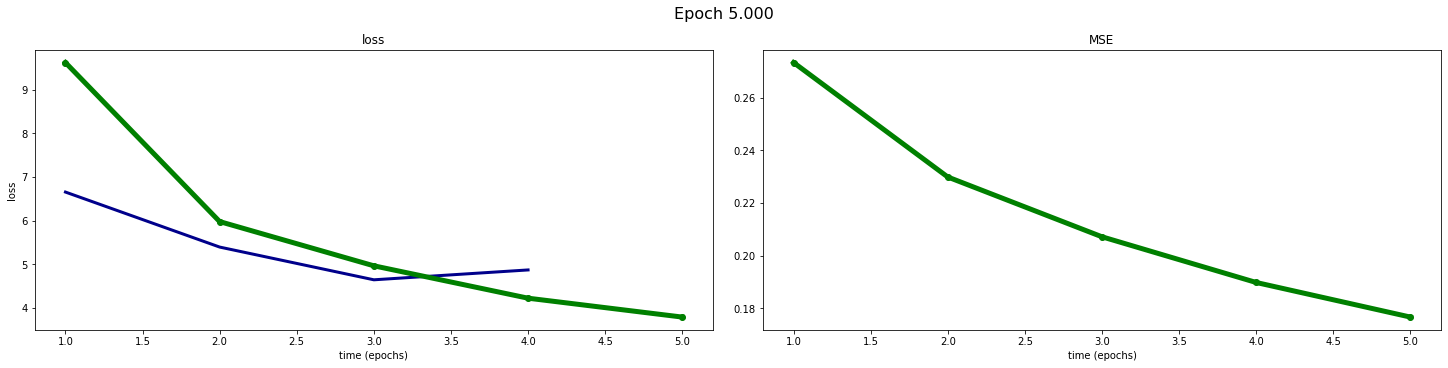

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorLSTM(token_to_id, 100, 5, pooling='average_pool', method=1).to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 


for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 6948.1709 Val Loss 9.6232 MSE 0.27326444611906076
Epoch 2 LR 0.0095 Train Loss 6.6560 Val Loss 5.9803 MSE 0.22984769104031336
Epoch 3 LR 0.0061 Train Loss 5.3961 Val Loss 4.9670 MSE 0.20717192734505863
Epoch 4 LR 0.0019 Train Loss 4.6464 Val Loss 4.2253 MSE 0.1898464111397945
Epoch 5 LR 0.0000 Train Loss 4.8722 Val Loss 3.7926 MSE 0.1767251367355068


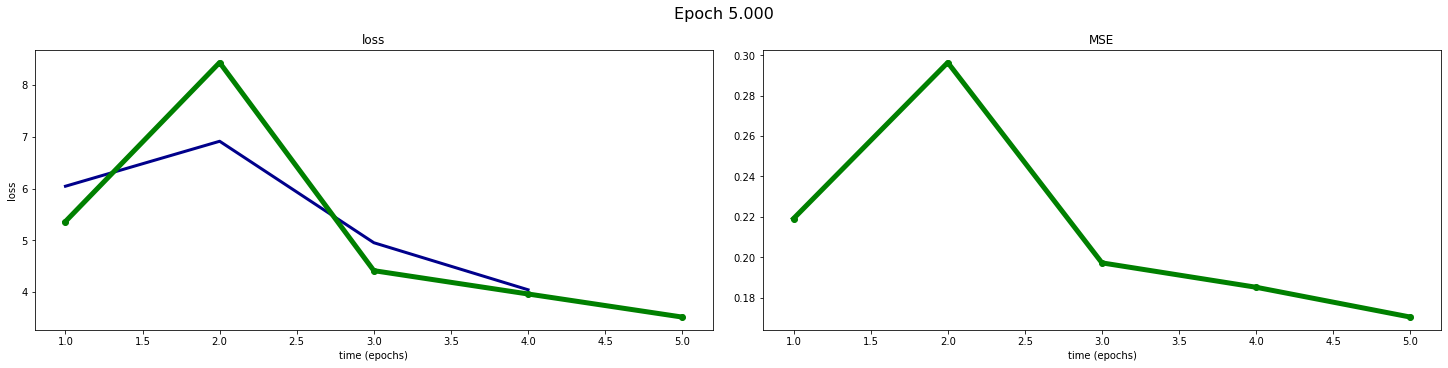

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorLSTM(token_to_id, 100, 5, pooling='average_pool', method=2).to(DEVICE)
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 


for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0076 Train Loss 7019.9287 Val Loss 5.3616 MSE 0.2191111689353781
Epoch 2 LR 0.0095 Train Loss 6.0443 Val Loss 8.4353 MSE 0.2963736125367692
Epoch 3 LR 0.0061 Train Loss 6.9136 Val Loss 4.4123 MSE 0.19718008551395189
Epoch 4 LR 0.0019 Train Loss 4.9521 Val Loss 3.9614 MSE 0.18510182231023
Epoch 5 LR 0.0000 Train Loss 4.0428 Val Loss 3.5151 MSE 0.1703458021497222


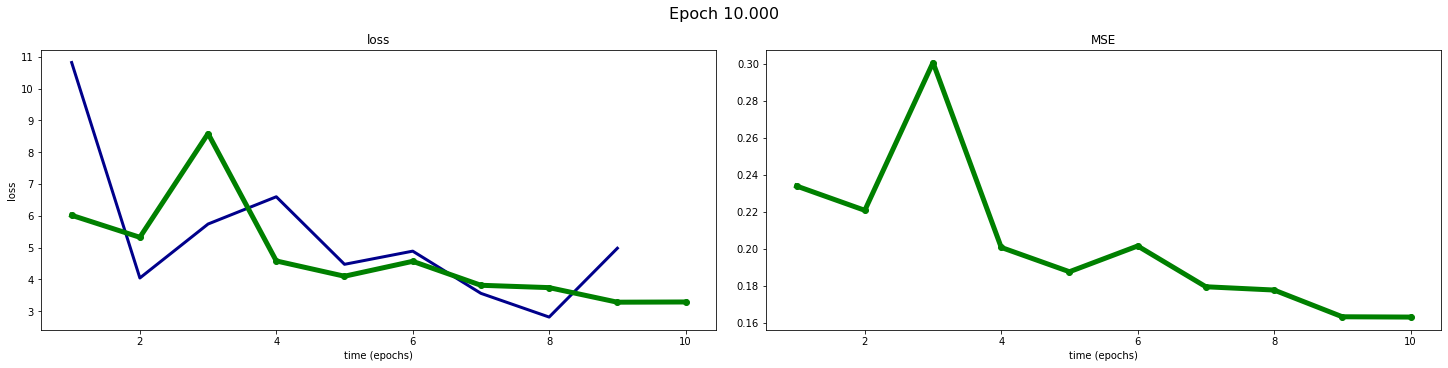

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorLSTM(token_to_id, 100, 5, pooling='average_pool', method=2).to(DEVICE)
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 


for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0028 Train Loss 7036.8867 Val Loss 6.0158 MSE 0.2340250222147322
Epoch 2 LR 0.0076 Train Loss 10.8192 Val Loss 5.3237 MSE 0.2209036680161478
Epoch 3 LR 0.0100 Train Loss 4.0440 Val Loss 8.5852 MSE 0.30073614627379786
Epoch 4 LR 0.0095 Train Loss 5.7414 Val Loss 4.5801 MSE 0.20086861677544227
Epoch 5 LR 0.0081 Train Loss 6.5981 Val Loss 4.0994 MSE 0.1877336576492728
Epoch 6 LR 0.0061 Train Loss 4.4742 Val Loss 4.5685 MSE 0.20164724952251092
Epoch 7 LR 0.0039 Train Loss 4.8886 Val Loss 3.8151 MSE 0.17962057253365404
Epoch 8 LR 0.0019 Train Loss 3.5609 Val Loss 3.7412 MSE 0.17785037595880826
Epoch 9 LR 0.0005 Train Loss 2.8152 Val Loss 3.2830 MSE 0.16341469000234915
Epoch 10 LR 0.0000 Train Loss 4.9800 Val Loss 3.2900 MSE 0.16324900711956633


## LSTM + CNN ENcoder
For Title CNN architecture used, for Description - LSTM

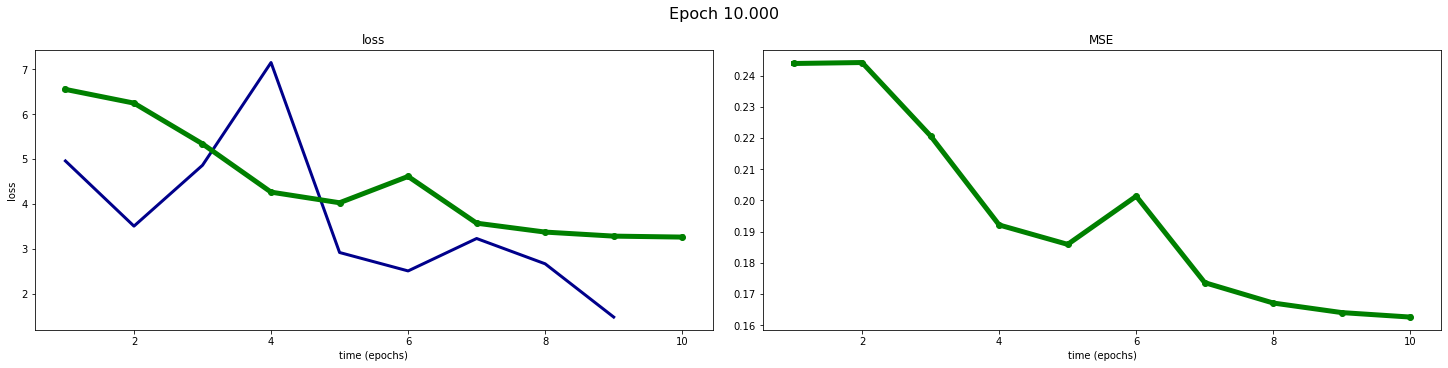

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc, lr = [], [], [], []
BATCH_SIZE = 64
model = SalaryPredictorCNN_LSTM(token_to_id, 100, 5, pooling='average_pool', kernels=[2, 3, 4]).to(DEVICE)
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.MSELoss(reduction='sum')
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=round((len(data_train) / BATCH_SIZE)) * epochs) 


for t in range(epochs):
    torch.cuda.empty_cache()
    train(t, data_train , model, criterion, optimizer, sched=sched)
    test(t, data_val, model, criterion)

In [ ]:
for epoch, l, t_loss, v_loss, acc in zip(val_ts, lr, train_loss, val_loss, val_acc):
    print(f"Epoch {epoch} LR {round(l, 4):.4f} Train Loss {round(t_loss, 4):.4f} Val Loss {round(v_loss, 4):.4f} MSE {acc}")

Epoch 1 LR 0.0028 Train Loss 6670.8667 Val Loss 6.5513 MSE 0.24390329681307962
Epoch 2 LR 0.0076 Train Loss 4.9580 Val Loss 6.2458 MSE 0.2442129385813723
Epoch 3 LR 0.0100 Train Loss 3.5061 Val Loss 5.3384 MSE 0.22067003031544918
Epoch 4 LR 0.0095 Train Loss 4.8620 Val Loss 4.2635 MSE 0.1921260743504106
Epoch 5 LR 0.0081 Train Loss 7.1497 Val Loss 4.0267 MSE 0.1859066475351861
Epoch 6 LR 0.0061 Train Loss 2.9189 Val Loss 4.6131 MSE 0.2013646181236467
Epoch 7 LR 0.0039 Train Loss 2.5084 Val Loss 3.5719 MSE 0.17362917786978593
Epoch 8 LR 0.0019 Train Loss 3.2305 Val Loss 3.3736 MSE 0.16709813437742574
Epoch 9 LR 0.0005 Train Loss 2.6668 Val Loss 3.2836 MSE 0.16403237765300077
Epoch 10 LR 0.0000 Train Loss 1.4808 Val Loss 3.2622 MSE 0.16259760637856457


# Results

В этой домашке, удалось поэксперементировать с различными архитектурами. Наиболее симпатичной мне показалось архитектура LSTM, где мы конкатим все хиден стейты, после чего берем average pooling. Самая лучшая модель по метрикам, та что использует разные инкодеры для title and desciption. (CNN and LSTM соответственно). 

Для оптимизации, я выбрала свои любимый OneCycleLR с большим batch size и провела эксперементы на 5 и 10 эпохах с разными моделями. 

Не очень эффективным оказалось использование pooling layer-ов с SoftMax и Attention, надеюсь это не потому что я неправильно их реализовала. 

Сравнение моделей можно увидеть в таблице ниже.

|Model                            |  MSE |
|---------------------------------|:-----|
|CNN                              |0.1725|
|CNN with pretrained embeddings   |0.1696|
|LSTM (last hiden representation) |0.1767|
|LSTM (average over time)         |0.1703|
|LSTM + CNN  (10 epochs)          |0.1625|